In [467]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [233]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [2]:
nutrients_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/PSFbottledata.mat')

In [3]:
ctd_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final.mat')

In [4]:
print(nutrients_2015.keys())
print(ctd_2015.keys())

dict_keys(['__header__', '__version__', '__globals__', 'PSFbottle'])
dict_keys(['__header__', '__version__', '__globals__', 'PSFc'])


In [5]:
ctd_data = ctd_2015[list(ctd_2015.keys())[3]]
nutrients_data = nutrients_2015[list(nutrients_2015.keys())[3]]

In [6]:
ctd_dtype = ctd_data.dtype
n_dtype = nutrients_data.dtype

In [7]:
ctddata = {n: ctd_data[n][0, 0] for n in ctd_dtype.names}
n_data = {n: nutrients_data[n][0, 0] for n in n_dtype.names}

In [8]:
print(ctddata.keys())
print(n_data.keys())

dict_keys(['patrol', 'ID', 'stn', 'mtime', 'lat', 'long', 'pr', 'mtimes', 'temp', 'sal', 'cond', 'depth', 'stnN', 'o2', 'chl', 'comment'])
dict_keys(['num', 'depth', 'mtime', 'station', 'lat', 'lon', 'no23', 'si', 'po4'])


In [74]:
ctd_times = ctd_data['mtime'][0,0][0,:]
print(ctd_times.shape)
n_times = n_data['mtime'][:,0]
print(n_times.shape)

(2142,)
(896,)


In [331]:
ctd_temps = ctd_data['temp'][0,0][:,:]
ctd_sals = ctd_data['sal'][0,0][:,:]
ctd_depths = ctd_data['depth'][0,0][:,:]

In [235]:
ctd_lons = ctd_data['long'][0,0][0,:]
ctd_lats = ctd_data['lat'][0,0][0,:]
n_lons = n_data['lon'][:,0]
n_lats = n_data['lat'][:,0]
n_si = n_data['si'][:,0]
n_no23 = n_data['no23'][:,0]
n_depths = n_data['depth'][:,0]

In [140]:
base = datetime.datetime(2000, 1, 1)
py_ctd_times = np.array([base for i in range(2142)])
print(py_ctd_times.shape)
for n in range(2142):
    py_ctd_times[n] = ((datetime.datetime.fromordinal(int(ctd_times[n])))
                       + datetime.timedelta(days=ctd_times[n]%1)
                       - datetime.timedelta(days = 366))

(2142,)


In [173]:
py_n_times = np.array([base for i in range(896)])
print(py_n_times.shape)
for m in range(896):
    a  =  (datetime.datetime.fromordinal(int(n_times[m])) 
           + datetime.timedelta(days=int(n_times[m])%1) 
           - datetime.timedelta(days = 366))
    py_n_times[m] = a

(896,)


In [146]:
nowcast = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02')

In [305]:
nowcast_phys = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [238]:
times_to_use = np.array([])
lats_to_use = np.array([])
lons_to_use = np.array([])
si_to_use = np.array([])
ni_to_use = np.array([])
depth_to_use = np.array([])
for i in range(896):
    same_day_index = np.array([])
    for n in range(2142):
        if ((py_ctd_times[n].day == py_n_times[i].day) 
            and (py_ctd_times[n].month == py_n_times[i].month)):
            same_day_index = np.append(same_day_index, n)
    if len(same_day_index) != 0:
        same_day_times = np.array([py_ctd_times[p] for p in same_day_index])
        same_day_lons = np.array([ctd_lons[m] for m in same_day_index])
        same_day_lats = np.array([ctd_lats[l] for l in same_day_index])
        a = np.argmin(np.abs(same_day_lats - n_lats[i]))
        b = np.argmin(np.abs(same_day_lons - n_lons[i]))
        if (a-b) == 0:
            times_to_use = np.append(times_to_use, same_day_times[a])
            lats_to_use = np.append(lats_to_use, n_lats[i])
            lons_to_use = np.append(lons_to_use, n_lons[i])
            si_to_use = np.append(si_to_use, n_si[i])
            ni_to_use = np.append(ni_to_use, n_no23[i])
            depth_to_use = np.append(depth_to_use, n_depths[i])

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [342]:
times_to_use2 = np.array([])
lats_to_use2 = np.array([])
lons_to_use2 = np.array([])
surface_sal_to_use = np.array([])
surface_temp_to_use = np.array([])
surface_depth_to_use = np.array([])
deeper_sal_to_use = np.array([])
deeper_temp_to_use = np.array([])
deeper_depth_to_use = np.array([])
for i in range(896):
    same_day_index = np.array([])
    for n in range(2142):
        if ((py_ctd_times[n].day == py_n_times[i].day) 
            and (py_ctd_times[n].month == py_n_times[i].month)):
            same_day_index = np.append(same_day_index, n)
    if len(same_day_index) != 0:
        same_day_times = np.array([py_ctd_times[p] for p in same_day_index])
        same_day_lons = np.array([ctd_lons[m] for m in same_day_index])
        same_day_lats = np.array([ctd_lats[l] for l in same_day_index])
        same_day_surface_sal = np.array([ctd_sals[0,l] for l in same_day_index])
        same_day_surface_temp = np.array([ctd_temps[0,l] for l in same_day_index])
        same_day_surface_depths = np.array([ctd_depths[0,l] for l in same_day_index])
        same_day_deeper_sal = np.array([ctd_sals[19,l] for l in same_day_index])
        same_day_deeper_temp = np.array([ctd_temps[19,l] for l in same_day_index])
        same_day_deeper_depths = np.array([ctd_depths[19,l] for l in same_day_index])
        a = np.argmin(np.abs(same_day_lats - n_lats[i]))
        b = np.argmin(np.abs(same_day_lons - n_lons[i]))
        if (a-b) == 0:
            times_to_use2 = np.append(times_to_use2, same_day_times[a])
            lats_to_use2 = np.append(lats_to_use2, same_day_lats[a])
            lons_to_use2 = np.append(lons_to_use2, same_day_lons[a])
            surface_sal_to_use = np.append(surface_sal_to_use, same_day_surface_sal[a])
            surface_temp_to_use = np.append(surface_temp_to_use, same_day_surface_temp[a])
            surface_depth_to_use = np.append(surface_depth_to_use, same_day_surface_depths[a])
            deeper_sal_to_use = np.append(deeper_sal_to_use, same_day_deeper_sal[a])
            deeper_temp_to_use = np.append(deeper_temp_to_use, same_day_deeper_temp[a])
            deeper_depth_to_use = np.append(deeper_depth_to_use, same_day_deeper_depths[a])

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__

In [229]:
print(times_to_use.shape)
print(si_to_use.shape)

(460,)
(460,)


In [234]:
times_to_use[9]

datetime.datetime(2015, 8, 5, 21, 10, 24, 941179)

In [227]:
nowcast_si = nowcast.silicon
nowcast_nitrate = nowcast.nitrate

In [241]:
depth_to_use[depth_to_use == 2] = 0.5

In [323]:
ctd_data['long'][0,0][0,:].shape

(2142,)

In [330]:
ctd_data['temp'][0,0].shape

(400, 2142)

In [328]:
ctd_data['depth'][0,0][19,:5]

array([ 20.,  20.,  20.,  20.,  20.])

In [248]:
list_of_model_si = np.array([])
list_of_model_ni = np.array([])
for n in range(460):
    Yind, Xind = geo_tools.find_closest_model_point(lons_to_use[n], 
                                                    lats_to_use[n], 
                                                    X, Y, land_mask = bathy.mask)
    date = times_to_use[n]
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        delta = (date - before).seconds / 3600
        si_val = (delta * ((nowcast_si
               .sel(time = before, depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_si
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        ni_val = (delta * ((nowcast_nitrate
               .sel(time = before, depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_nitrate
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        delta = (date - before).seconds / 3600
        si_val = (delta * ((nowcast_si
               .sel(time = before, depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_si
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        ni_val = (delta * ((nowcast_nitrate
               .sel(time = before, depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_si
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = depth_to_use[n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    list_of_model_si = np.append(list_of_model_si, si_val)
    list_of_model_ni = np.append(list_of_model_ni, ni_val)

bias =  2.41711940087
RMSE = 8.6476578678
Willmott = 0.834773510232


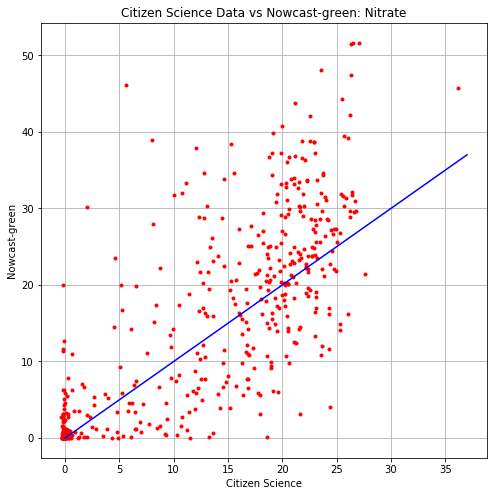

In [290]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(ni_to_use, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(ni_to_use) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - ni_to_use)**2) /
                              len(list_of_model_ni))))
xbar = np.mean(ni_to_use)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - ni_to_use)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(ni_to_use - xbar))**2))))

bias =  -8.68815881594
RMSE = 14.8026979194
Willmott = 0.779597988194


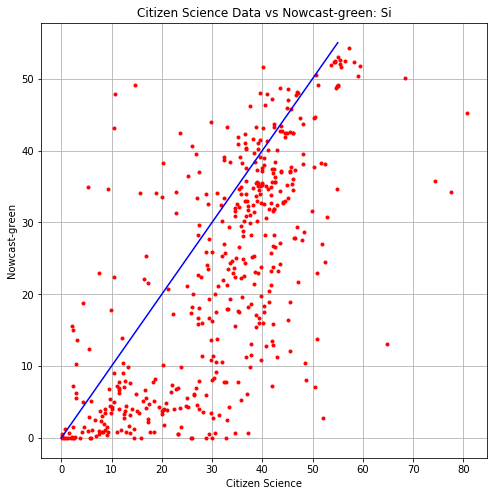

In [289]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(si_to_use, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(si_to_use) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - si_to_use)**2) /
                              len(list_of_model_si))))
xbar = np.mean(si_to_use)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - si_to_use)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(si_to_use - xbar))**2))))

In [425]:
surface_si_model = np.array([])
surface_ni_model = np.array([])
deeper_si_model = np.array([])
deeper_ni_model = np.array([])
surface_si_cs = np.array([])
surface_ni_cs = np.array([])
deeper_si_cs = np.array([])
deeper_ni_cs = np.array([])
deeper_lats = np.array([])
surface_lats = np.array([])
deeper_times = np.array([])
surface_times = np.array([])
for n in range(460):
    if depth_to_use[n] == 20:
        deeper_si_model = np.append(deeper_si_model, list_of_model_si[n])
        deeper_si_cs = np.append(deeper_si_cs, si_to_use[n])
        deeper_ni_model = np.append(deeper_ni_model, list_of_model_ni[n])
        deeper_ni_cs = np.append(deeper_ni_cs, ni_to_use[n])
        deeper_lats = np.append(deeper_lats, lats_to_use[n])
        deeper_times = np.append(deeper_times, times_to_use[n])
    if depth_to_use[n] < 5:
        surface_si_model = np.append(surface_si_model, list_of_model_si[n])
        surface_si_cs = np.append(surface_si_cs, si_to_use[n])
        surface_ni_model = np.append(surface_ni_model, list_of_model_ni[n])
        surface_ni_cs = np.append(surface_ni_cs, ni_to_use[n])
        surface_lats = np.append(surface_lats, lats_to_use[n])
        surface_times = np.append(surface_times, times_to_use[n])

In [461]:
deeper_lons = np.array([])
surface_lons = np.array([])
for n in range(460):
    if depth_to_use[n] == 20:
        deeper_lons = np.append(deeper_lons, lons_to_use[n])
    if depth_to_use[n] < 5:
        surface_lons = np.append(surface_lons, lons_to_use[n])

bias =  1.8254908532
RMSE = 7.26780545659
Willmott = 0.859292590741


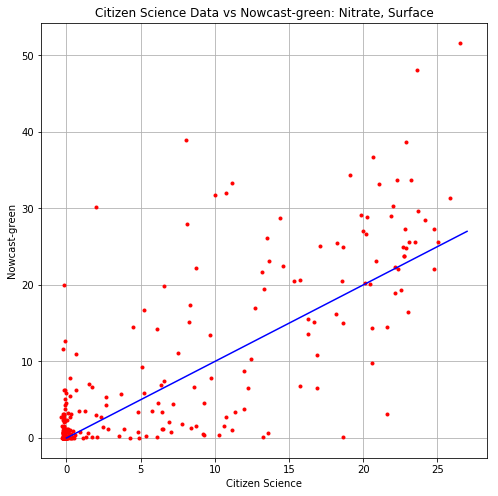

In [281]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_ni_cs, surface_ni_model, 'r.')
ax.plot(np.arange(0,28), np.arange(0,28), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate, Surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_ni_cs) + np.mean(surface_ni_model)))
print('RMSE = ' + str(np.sqrt(np.sum((surface_ni_model - surface_ni_cs)**2) /
                              len(surface_ni_cs))))
xbar = np.mean(surface_ni_cs)
print('Willmott = ' + str(1-(np.sum((surface_ni_model - surface_ni_cs)**2)  / 
                             np.sum((np.abs(surface_ni_model - xbar) 
                                     + np.abs(surface_ni_cs - xbar))**2))))

bias =  3.00874794853
RMSE = 9.83580078296
Willmott = 0.566060446826


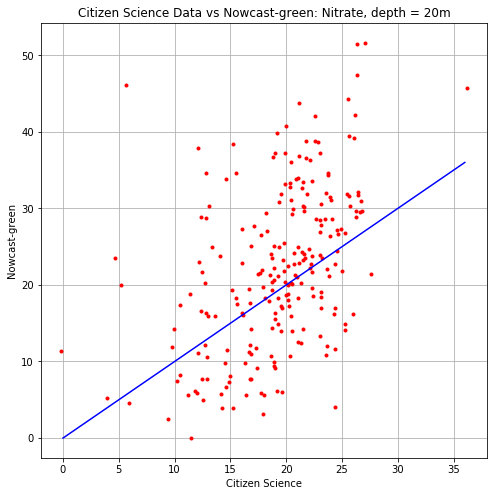

In [282]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(deeper_ni_cs, deeper_ni_model, 'r.')
ax.plot(np.arange(0,37), np.arange(0,37), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate, depth = 20m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(deeper_ni_cs) + np.mean(deeper_ni_model)))
print('RMSE = ' + str(np.sqrt(np.sum((deeper_ni_model - deeper_ni_cs)**2) /
                              len(deeper_ni_cs))))
xbar = np.mean(deeper_ni_cs)
print('Willmott = ' + str(1-(np.sum((deeper_ni_model - deeper_ni_cs)**2)  / 
                             np.sum((np.abs(deeper_ni_model - xbar) 
                                     + np.abs(deeper_ni_cs - xbar))**2))))

bias =  -9.80669982283
RMSE = 15.3488589571
Willmott = 0.77394458431


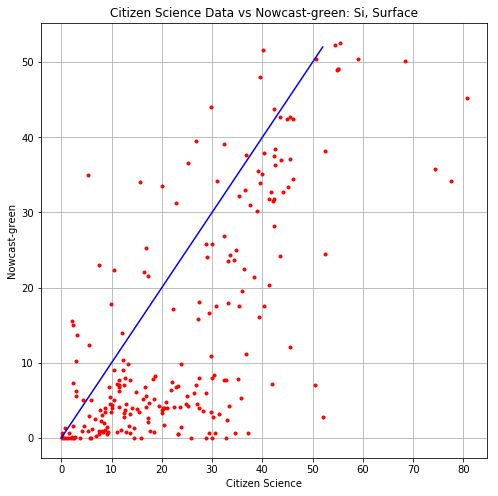

In [285]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_si_cs, surface_si_model, 'r.')
ax.plot(np.arange(0,53), np.arange(0,53), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si, Surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_si_cs) + np.mean(surface_si_model)))
print('RMSE = ' + str(np.sqrt(np.sum((surface_si_model - surface_si_cs)**2) /
                              len(surface_si_cs))))
xbar = np.mean(surface_si_cs)
print('Willmott = ' + str(1-(np.sum((surface_si_model - surface_si_cs)**2)  / 
                             np.sum((np.abs(surface_si_model - xbar) 
                                     + np.abs(surface_si_cs - xbar))**2))))

bias =  -7.56961780905
RMSE = 14.2355983402
Willmott = 0.526497330842


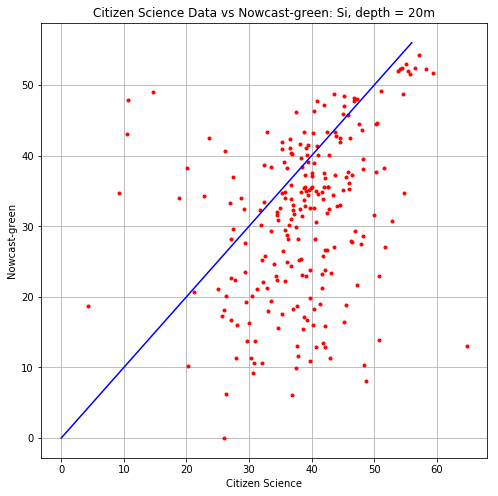

In [288]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(deeper_si_cs, deeper_si_model, 'r.')
ax.plot(np.arange(0,57), np.arange(0,57), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si, depth = 20m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(deeper_si_cs) + np.mean(deeper_si_model)))
print('RMSE = ' + str(np.sqrt(np.sum((deeper_si_model - deeper_si_cs)**2) /
                              len(deeper_si_cs))))
xbar = np.mean(deeper_si_cs)
print('Willmott = ' + str(1-(np.sum((deeper_si_model - deeper_si_cs)**2)  / 
                             np.sum((np.abs(deeper_si_model - xbar) 
                                     + np.abs(deeper_si_cs - xbar))**2))))

In [ ]:
times_to_use2 = np.array([])
lats_to_use2 = np.array([])
lons_to_use2 = np.array([])
surface_sal_to_use = np.array([])
surface_temp_to_use = np.array([])
surface_depth_to_use = np.array([])
deeper_sal_to_use = np.array([])
deeper_temp_to_use = np.array([])
deeper_depth_to_use = np.array([])

In [346]:
nowcast_salinity = nowcast_phys.salinity
nowcast_temp = nowcast_phys.temperature

In [347]:
list_of_model_surface_sal = np.array([])
list_of_model_surface_temp = np.array([])
for n in range(460):
    Yind, Xind = geo_tools.find_closest_model_point(lons_to_use2[n], 
                                                    lats_to_use2[n], 
                                                    X, Y, land_mask = bathy.mask)
    date = times_to_use2[n]
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        delta = (date - before).seconds / 3600
        sal_val = (delta * ((nowcast_salinity
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        tem_val = (delta * ((nowcast_temp
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_temp
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        delta = (date - before).seconds / 3600
        sal_val = (delta * ((nowcast_salinity
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        tem_val = (delta * ((nowcast_temp
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_temp
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    list_of_model_surface_sal = np.append(list_of_model_surface_sal, sal_val)
    list_of_model_surface_temp = np.append(list_of_model_surface_temp, tem_val)

In [365]:
masked_deeper_depths_to_use = np.ma.masked_invalid(deeper_depth_to_use)

In [407]:
f = nc.Dataset('/results/SalishSea/nowcast-green/01oct17/SalishSea_1h_20171001_20171001_ptrc_T.nc')

In [412]:
list_of_model_deeper_sal = np.ma.masked_array(np.zeros((460)), mask = True)
list_of_model_deeper_temp = np.ma.masked_array(np.zeros((460)), mask = True)
for n in range(460):
    Yind, Xind = geo_tools.find_closest_model_point(lons_to_use2[n], 
                                                    lats_to_use2[n], 
                                                    X, Y, land_mask = bathy.mask)
    date = times_to_use2[n]
    if ((masked_deeper_depths_to_use.mask[n] == False) and 
        (mesh.variables['tmask'][0,18, Yind, Xind] == 1)):
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            delta = (date - before).seconds / 3600
            sal_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
            tem_val = (delta * ((nowcast_temp
                   .sel(time = before, depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_temp
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            delta = (date - before).seconds / 3600
            sal_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
            tem_val = (delta * ((nowcast_temp
                   .sel(time = before, depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_temp
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = deeper_depth_to_use[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        list_of_model_deeper_sal[n].mask = False
        list_of_model_deeper_sal[n] = sal_val
        list_of_model_deeper_temp[n].mask = False
        list_of_model_deeper_temp[n] = tem_val

bias =  -1.37382901767
RMSE = 2.61684018459
Willmott = 0.83782067416


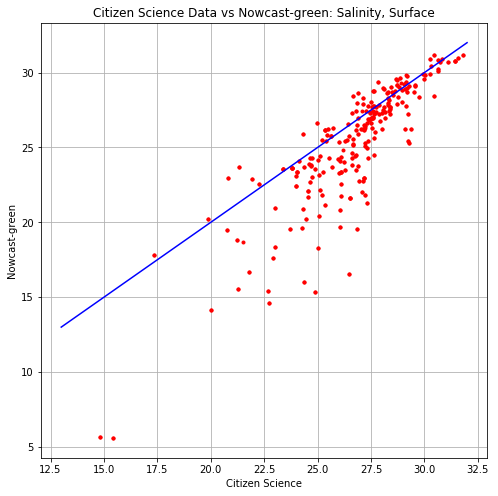

In [383]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_sal_to_use, list_of_model_surface_sal, 'r.')
ax.plot(np.arange(13,33), np.arange(13,33), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Salinity, Surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_sal_to_use) + np.mean(list_of_model_surface_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_surface_sal - surface_sal_to_use)**2) /
                              len(surface_sal_to_use))))
xbar = np.mean(surface_sal_to_use)
print('Willmott = ' + str(1-(np.sum((list_of_model_surface_sal - surface_sal_to_use)**2)  / 
                             np.sum((np.abs(list_of_model_surface_sal - xbar) 
                                     + np.abs(surface_sal_to_use - xbar))**2))))

bias =  0.237268574118
RMSE = 1.09097150808
Willmott = 0.980119115951


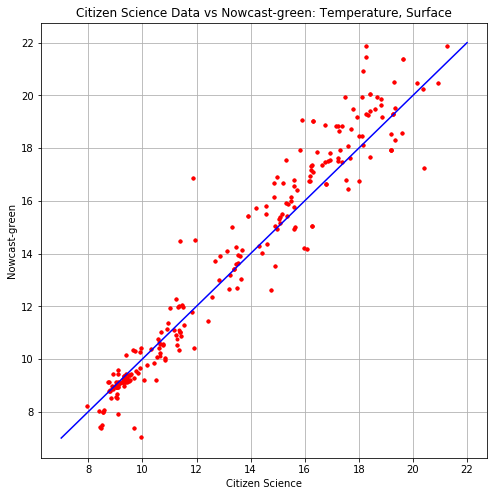

In [386]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_temp_to_use, list_of_model_surface_temp, 'r.')
ax.plot(np.arange(7,23), np.arange(7,23), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Temperature, Surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_temp_to_use) + np.mean(list_of_model_surface_temp)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_surface_temp - surface_temp_to_use)**2) /
                              len(surface_temp_to_use))))
xbar = np.mean(surface_temp_to_use)
print('Willmott = ' + str(1-(np.sum((list_of_model_surface_temp - surface_temp_to_use)**2)  / 
                             np.sum((np.abs(list_of_model_surface_temp - xbar) 
                                     + np.abs(surface_temp_to_use - xbar))**2))))

In [414]:
masked_ctd_deeper_sal = np.ma.masked_array(deeper_sal_to_use,
                                          mask = list_of_model_deeper_sal.mask)
masked_ctd_deeper_temp = np.ma.masked_array(deeper_temp_to_use,
                                           mask = list_of_model_deeper_temp.mask)

bias =  0.0972064107767
RMSE = 0.519753552971
Willmott = 0.849520412478


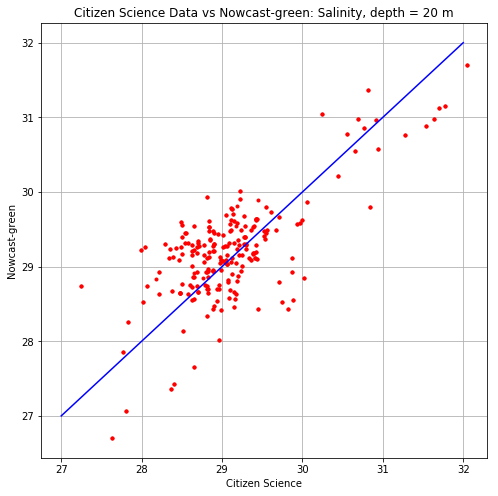

In [416]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(masked_ctd_deeper_sal, list_of_model_deeper_sal, 'r.')
ax.plot(np.arange(27,33), np.arange(27,33), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Salinity, depth = 20 m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(masked_ctd_deeper_sal) + np.mean(list_of_model_deeper_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_deeper_sal - masked_ctd_deeper_sal)**2) /
                              np.ma.count(masked_ctd_deeper_sal))))
xbar = np.mean(masked_ctd_deeper_sal)
print('Willmott = ' + str(1-(np.sum((list_of_model_deeper_sal - masked_ctd_deeper_sal)**2)  / 
                             np.sum((np.abs(list_of_model_deeper_sal - xbar) 
                                     + np.abs(masked_ctd_deeper_sal - xbar))**2))))

bias =  -0.0797126790764
RMSE = 0.51943616054
Willmott = 0.96454961251


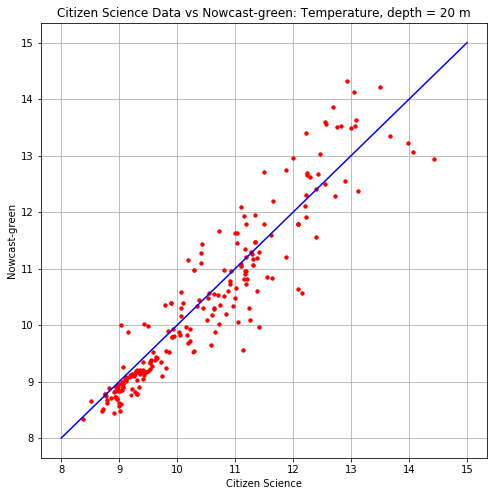

In [421]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(masked_ctd_deeper_temp, list_of_model_deeper_temp, 'r.')
ax.plot(np.arange(8,16), np.arange(8,16), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Temperature, depth = 20 m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(masked_ctd_deeper_temp) + np.mean(list_of_model_deeper_temp)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_deeper_temp - masked_ctd_deeper_temp)**2) /
                              np.ma.count(masked_ctd_deeper_temp))))
xbar = np.mean(masked_ctd_deeper_temp)
print('Willmott = ' + str(1-(np.sum((list_of_model_deeper_temp - masked_ctd_deeper_temp)**2)  / 
                             np.sum((np.abs(list_of_model_deeper_temp - xbar) 
                                     + np.abs(masked_ctd_deeper_temp - xbar))**2))))

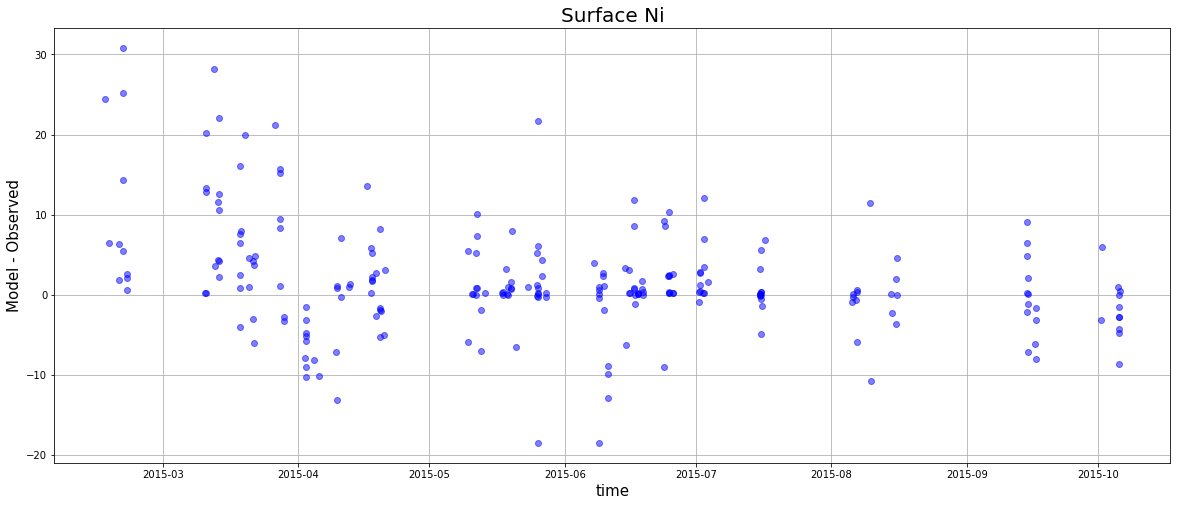

In [451]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_times, surface_ni_model - surface_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Ni', fontsize = 20)

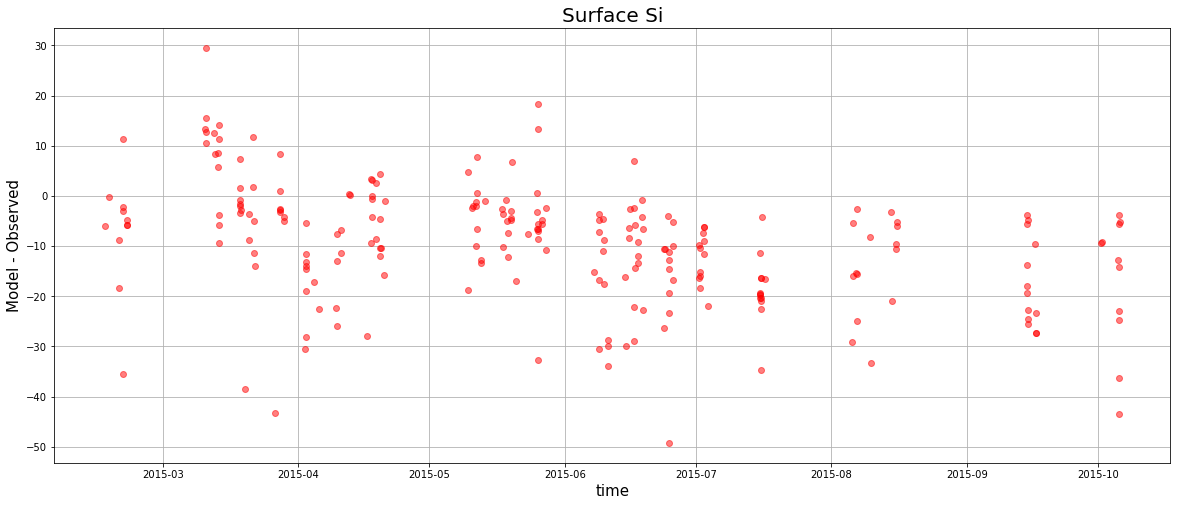

In [452]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_times, surface_si_model - surface_si_cs, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Si', fontsize = 20)
ax.grid('on')

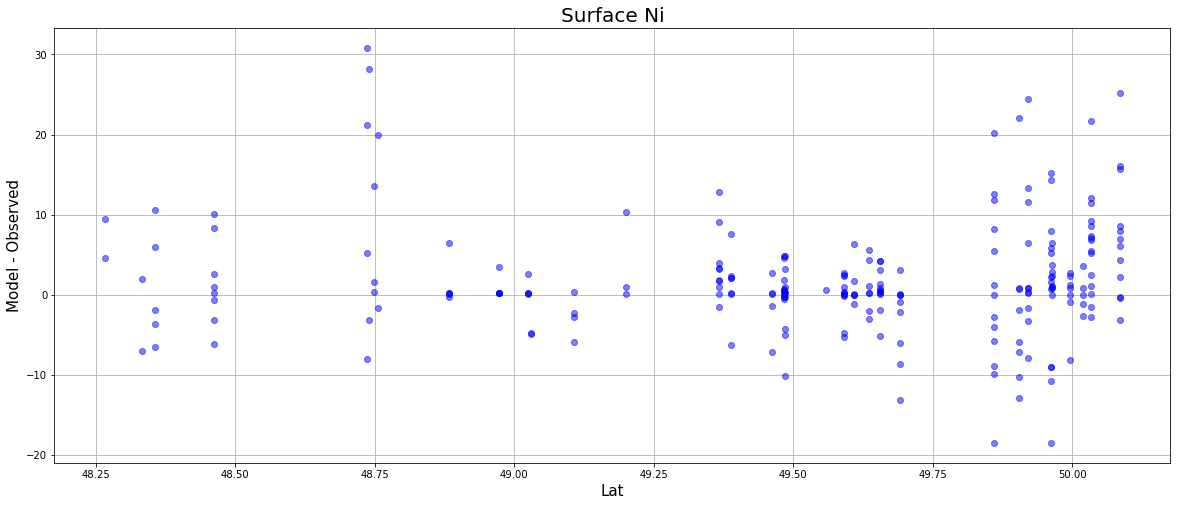

In [454]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_lats, surface_ni_model - surface_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Ni', fontsize = 20)
ax.grid('on')

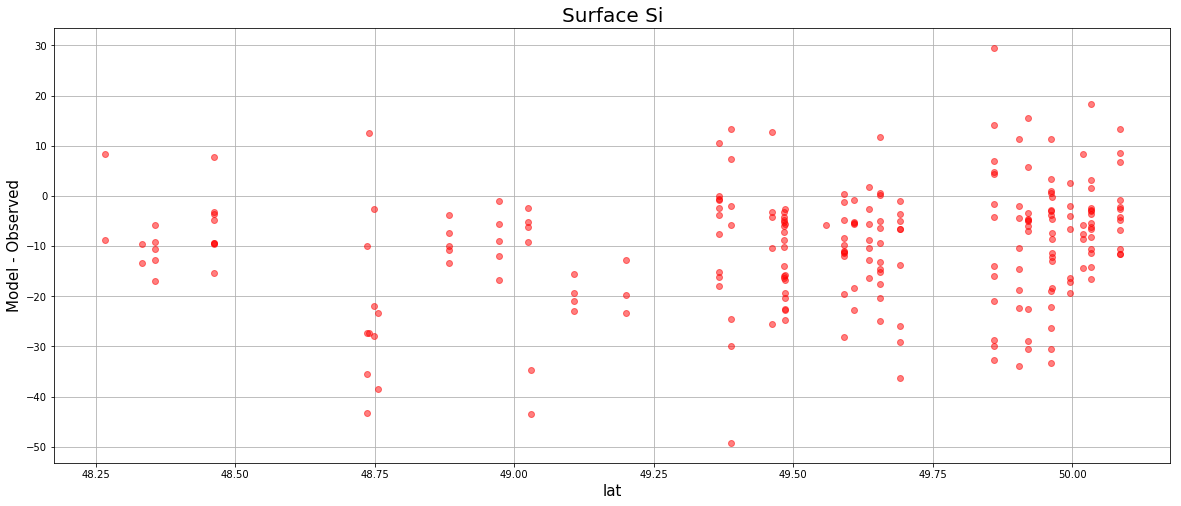

In [455]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_lats, surface_si_model - surface_si_cs, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Surface Si', fontsize = 20)

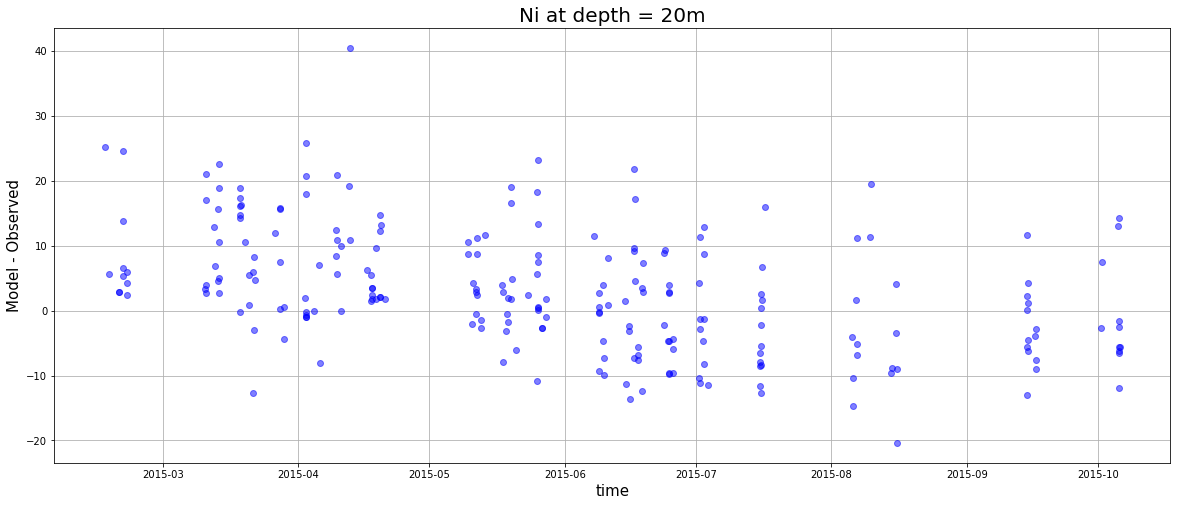

In [456]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_times, deeper_ni_model - deeper_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni at depth = 20m', fontsize = 20)

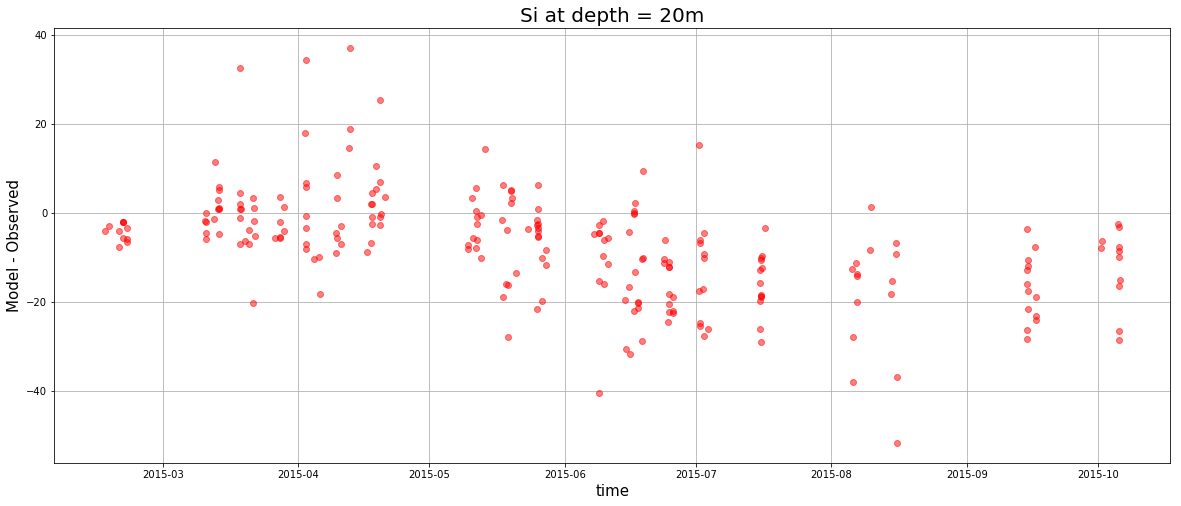

In [457]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_times, deeper_si_model - deeper_si_cs,'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si at depth = 20m', fontsize = 20)

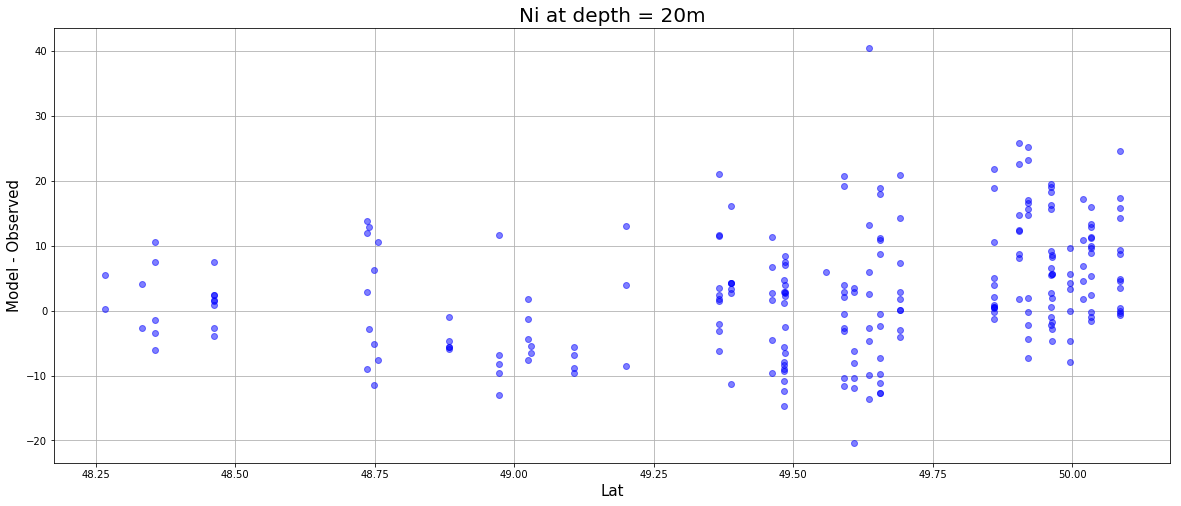

In [458]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_lats, deeper_ni_model - deeper_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni at depth = 20m', fontsize = 20)

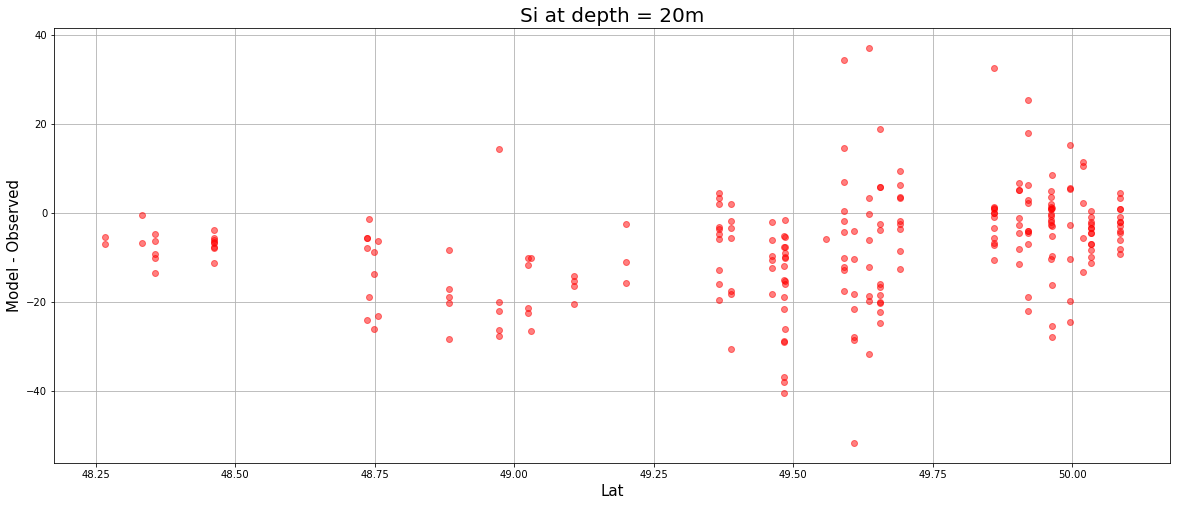

In [459]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_lats, deeper_si_model - deeper_si_cs,'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si at depth = 20m', fontsize = 20)

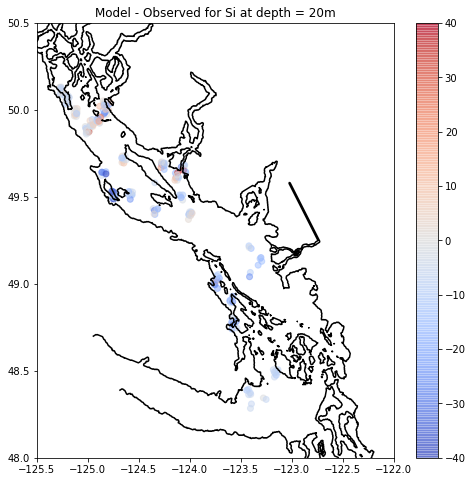

In [560]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((230))), 
                  deeper_lats + 0.05*np.random.random(size=((230))) , 
                  c = (deeper_si_model - deeper_si_cs), cmap = 'coolwarm', alpha =0.5)
diff.set_clim([-40,40])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for Si at depth = 20m')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);

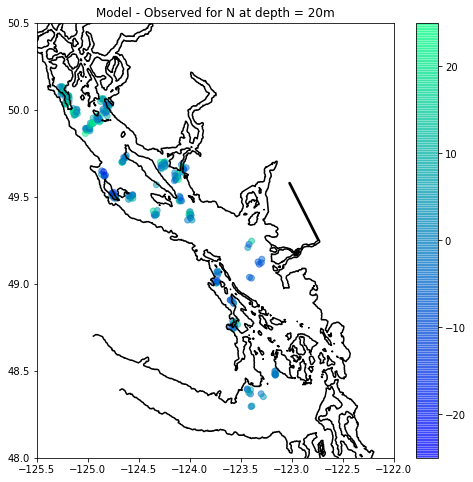

In [559]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((230))), 
                  deeper_lats + 0.05*np.random.random(size=((230))), 
                  c = (deeper_ni_model - deeper_ni_cs), cmap = 'winter', alpha = 0.5)
diff.set_clim([-25,25])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for N at depth = 20m')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);

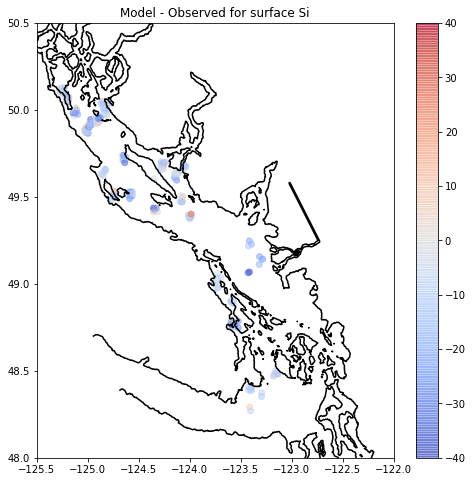

In [558]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((230))), 
                  deeper_lats + 0.05*np.random.random(size=((230))),
                  c = (surface_si_model - surface_si_cs), cmap = 'coolwarm', alpha = 0.5)
diff.set_clim([-40,40])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for surface Si')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);

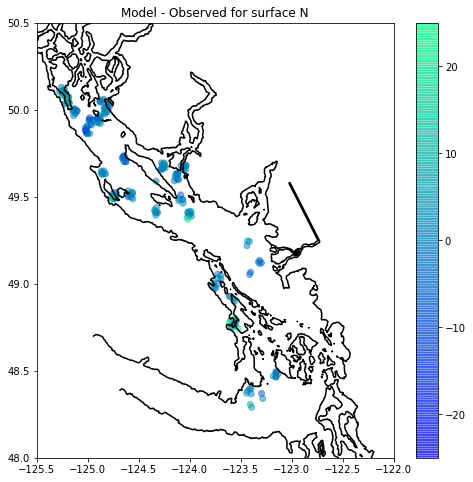

In [561]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((230))), 
                  deeper_lats + 0.05*np.random.random(size=((230))),
                  c = (surface_ni_model - surface_ni_cs), cmap = 'winter', 
                  vmin = -25, vmax =25, alpha=0.5)
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for surface N')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);